In [2]:
import torch
from datasets import concatenate_datasets

import sys
sys.path.append('./src')

from data import load_data, get_data_sl
from visualize import plot_outcome_distribution
from model import get_model
from causal import compute_ead

## Load Data

In [3]:
train = load_data(environment='train')
test = load_data(environment='test')

### Sanity Check

In [ ]:
model_name = "vit"
processor, model = get_model(model_name)

In [ ]:
inputs = processor(images=train[0]['image'], return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
print("Top 5 predicted labels with associated probabilities:")
top_5 = torch.topk(logits, 5)
probs = logits.softmax(-1)[0][top_5.indices][0]
for i, (idx, prob) in enumerate(zip(top_5.indices[0], probs), 1):
    print(f"    {i}. {model.config.id2label[idx.item()]}: {prob.item():.2%}")

In [ ]:
inputs = processor(images=train[0]['image'], return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)
outputs.hidden_states[-1][:,0].shape
# outputs.hidden_states[-1].mean(dim=[2,3]).shape

In [ ]:
test["outcome"].sum()

## Supervised Learning

In [3]:
X, y = get_data_sl(environment="train", model_name="dino")

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

outcome_idx = 0

model = LogisticRegression(solver='liblinear', max_iter=10) 
model.fit(X, y[:,outcome_idx])

y_pred = model.predict(X)  
print(classification_report(y[:,outcome_idx], y_pred))

/nfs/scistore19/locatgrp/rcadei/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95    204663
         1.0       0.77      0.60      0.67     32937

    accuracy                           0.92    237600
   macro avg       0.85      0.79      0.81    237600
weighted avg       0.91      0.92      0.92    237600



In [43]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

num_epochs = 2
input_size = X.shape[1]
hidden_size = 100
output_size = 2

# Define the model
model = Sequential([
    Dense(hidden_size, activation='relu', input_shape=(input_size,)),
    Dense(output_size) 
])

# Compile with optimizer and loss
model.compile(optimizer='adam', loss='mse') 

# Fit (training)
model.fit(np.array(X), np.array(y), epochs=num_epochs, batch_size=32) 

/nfs/scistore19/locatgrp/rcadei/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'

In [17]:
import svmutil  
from sklearn.metrics import classification_report

outcome_idx = 0

prob = svmutil.svm_problem(y[:, otcome_idx], X)
param = svmutil.svm_parameter('-s 0 -t 2 -c 1 -g 0.1')  
model = svmutil.svm_train(prob, param) 

y_pred = model.predict(X)  
print(classification_report(y[:,outcome_idx], y_pred))

ModuleNotFoundError: No module named 'svmutil'

In [ ]:
import matplotlib.pyplot as plt

id_1s = (torch.Tensor(y_pred) == 1).nonzero(as_tuple=True)[0]#[0]
id_1 = id_1s[0].item()

train = load_data(environment='train')
example = train[id_1]["image"]

img = example.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()

## Causal Inference

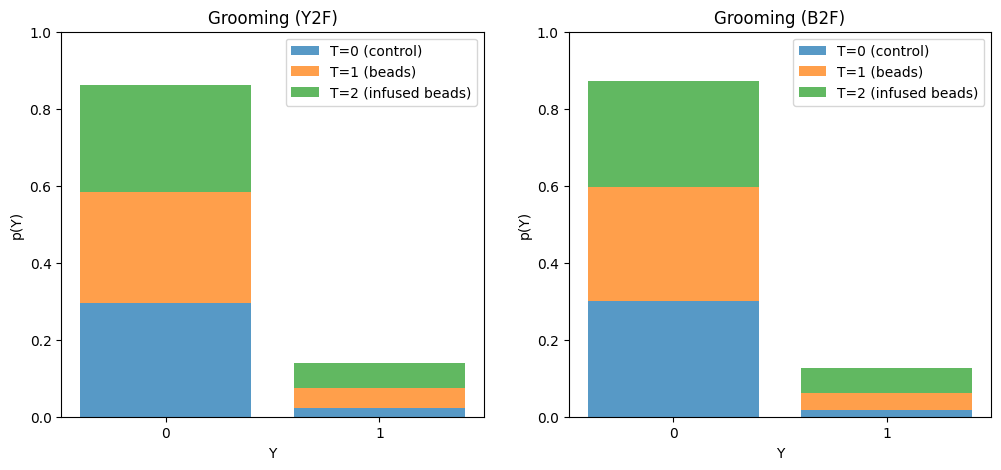

In [7]:
plot_outcome_distribution(train, save=True)

In [4]:
rct = train #concatenate_datasets([train, test])
Y = rct["outcome"]
T = rct["treatment"]

EAD_B_y, EAD_inf_y = compute_ead(Y, T, color="Yellow")   
EAD_B_b, EAD_inf_b = compute_ead(Y, T, color="Blue")   

Grooming: Yellow to Focal (Y2F)
EAD_B: 0.088 (+129%)
EAD_inf: 0.120 (+177%)
Grooming: Blue to Focal (B2F)
EAD_B: 0.076 (+137%)
EAD_inf: 0.138 (+250%)
